# Final Project
### DSCI 617
**Ryan Johnson**

### Overview

You have just been hired as a Sr. Data Scientist at the City of Chicago. Your manager, the mayor, Mr. Emanuel, asked you to download the dataset from https://www.kaggle.com/chicago/chicago-taxi-rides-2016. It is a very large dataset containing about 20 million records. This dataset includes taxi trips for 2016, which were reported to the City of Chicago in its role as a regulatory agency. To protect privacy but allow for aggregate analyses, the Taxi ID is consistent for any given taxi medallion number but does not show the number. Census Tracts are suppressed in some cases, and times are rounded to the nearest 15 minutes. Due to the data reporting process, not all trips are reported, but the City believes that most are. See http://digital.cityofchicago.org/index.php/chicago-taxi-data-released (Links to an external site.)Links to an external site for more information about this dataset and how it was created.

# Set Up for Databricks

In [0]:
import sys
from random import random
from operator import add
from pyspark.sql import SparkSession # starting point for PySpark with the DataFrame API and the Dataset

# create a new Spark session with the application name "Final Project"
spark = SparkSession\
    .builder\
    .appName("Final Project")\
    .getOrCreate()

# 1. Read 12 monthly datasets, chicago_taxi_trips_2016_01, chicago_taxi_trips_2016_02, …, chicago_taxi_trips_2016_12 into a Spark Data frame(Hint: you can use df = spark.read.csv('C:\\Users\\yliu3\\Documents\\Data Banks\\Regression\\chicago-taxi-rides-2016\\*.csv', header = True, inferSchema = True) to read several csv files and combine it into a single data frame)

In [0]:
# Use dbutils to list files in Databricks filesystem

def list_files(directory):
    """Lists all files in the specified directory in Databricks.

    Args:
        directory: The path to the directory.

    Returns:
        A list of file paths.
    """
    files = dbutils.fs.ls(directory)
    return [file.path for file in files]

# Specify the directory path
directory_path =  "dbfs:/FileStore/tables/taxi/"

# Get the list of files
file_list = list_files(directory_path)

# Print the file names
for file in file_list:
    print(file)

# Read all files in the directory into a single DataFrame
# Assuming the files are in CSV format. Adjust the format as needed (e.g., json, parquet).
df = spark.read.format("csv").option("header", "true").load(directory_path)

# Display the first 5 rows of the DataFrame
df.show(5)

dbfs:/FileStore/tables/taxi/chicago_taxi_trips_2016_01.csv
dbfs:/FileStore/tables/taxi/chicago_taxi_trips_2016_02.csv
dbfs:/FileStore/tables/taxi/chicago_taxi_trips_2016_03.csv
dbfs:/FileStore/tables/taxi/chicago_taxi_trips_2016_04.csv
dbfs:/FileStore/tables/taxi/chicago_taxi_trips_2016_05.csv
dbfs:/FileStore/tables/taxi/chicago_taxi_trips_2016_06.csv
dbfs:/FileStore/tables/taxi/chicago_taxi_trips_2016_07.csv
dbfs:/FileStore/tables/taxi/chicago_taxi_trips_2016_08.csv
dbfs:/FileStore/tables/taxi/chicago_taxi_trips_2016_09.csv
dbfs:/FileStore/tables/taxi/chicago_taxi_trips_2016_10.csv
dbfs:/FileStore/tables/taxi/chicago_taxi_trips_2016_11.csv
dbfs:/FileStore/tables/taxi/chicago_taxi_trips_2016_12.csv
dbfs:/FileStore/tables/taxi/column_remapping.json
dbfs:/FileStore/tables/taxi/data_dictionary.csv
dbfs:/FileStore/tables/taxi/dt_predictions.csv/
dbfs:/FileStore/tables/taxi/gbt_predictions.csv/
dbfs:/FileStore/tables/taxi/lr_predictions.csv/
dbfs:/FileStore/tables/taxi/rf_predictions.csv/
+

In [0]:
# df.printSchema()

### Converting fare, trip_seconds, and trip_miles columns to the correct formats (integer, double)
Currently all the datasets imported have all the columns as strings, that is not correct.

In [0]:
from pyspark.sql.types import DoubleType, IntegerType

df = df.withColumn("fare", df["fare"].cast(DoubleType())) # convert fare to double
df = df.withColumn("trip_seconds", df["trip_seconds"].cast(IntegerType())) # convert trip_seconds to integer
df = df.withColumn("trip_miles", df["trip_miles"].cast(DoubleType())) # convert trip_miles to double

df.printSchema()

root
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: string (nullable = true)
 |-- trip_end_timestamp: string (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_census_tract: string (nullable = true)
 |-- dropoff_census_tract: string (nullable = true)
 |-- pickup_community_area: string (nullable = true)
 |-- dropoff_community_area: string (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: string (nullable = true)
 |-- tolls: string (nullable = true)
 |-- extras: string (nullable = true)
 |-- trip_total: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)



## **Selecting fare, trip_seconds, and trip_miles columns and running all data**

In [0]:
df = df.select('fare', 'trip_seconds', 'trip_miles')

print(f"The shape of df is: rows: {df.count()} and columns: {len(df.columns)}")

df.show(5)

The shape of df is: rows: 19866178 and columns: 3
+-----+------------+----------+
| fare|trip_seconds|trip_miles|
+-----+------------+----------+
|  4.5|         180|       0.4|
| 4.45|         240|       0.7|
|42.75|           0|       0.0|
|  7.0|         480|       1.1|
|10.25|         480|      2.71|
+-----+------------+----------+
only showing top 5 rows



# 2. There are some missing values in fare ,trip_seconds,  and trip_miles , please drop the NAs in these three columns only using df = df.na.drop(subset= [])

Find the total count of NA, Null, None, and NaN from the selected columns fare,trip_seconds, and trip_miles https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/#:~:text=In%20PySpark%20DataFrame%20you%20can,count()%20and%20when().

In [0]:
df.select('fare', 'trip_seconds', 'trip_miles').printSchema()

root
 |-- fare: double (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)



In [0]:
# Find the total count of NA, Null, None, and NaN from the selected columns fare,trip_seconds, and trip_miles
from pyspark.sql.functions import col,isnan, when, count

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ['fare', 'trip_seconds', 'trip_miles']]).show()

+----+------------+----------+
|fare|trip_seconds|trip_miles|
+----+------------+----------+
| 321|        3236|       253|
+----+------------+----------+



In [0]:
# please drop the NAs in these three columns only using df = df.na.drop(subset= [])
df = df.na.drop(subset= ['fare', 'trip_seconds', 'trip_miles'])

In [0]:
# After drop finding total count of NA, Null, None, NaN from the selected columns fare ,trip_seconds, and trip_miles
# making sure that they were dopped

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ['fare', 'trip_seconds', 'trip_miles']]).show()

+----+------------+----------+
|fare|trip_seconds|trip_miles|
+----+------------+----------+
|   0|           0|         0|
+----+------------+----------+



# 3. Please remove the outliers from the dataset.
(For example, one potential method, https://en.wikipedia.org/wiki/Interquartile_range#:~:text=In%20descriptive%20statistics%2C%20the%20interquartile,25th%20percentiles%20of%20the%20data. to an external site. )

https://www.machinelearningplus.com/pyspark/pyspark-outlier-detection-and-treatment/

In [0]:
df.show(1)

+----+------------+----------+
|fare|trip_seconds|trip_miles|
+----+------------+----------+
| 4.5|         180|       0.4|
+----+------------+----------+
only showing top 1 row



In [0]:
# Using summary to see the min, 25%, 50%, 75%, and max
df.summary().show()

+-------+------------------+------------------+------------------+
|summary|              fare|      trip_seconds|        trip_miles|
+-------+------------------+------------------+------------------+
|  count|          19862606|          19862606|          19862606|
|   mean| 13.89208666476089| 767.0163579240307|3.3946843702198923|
| stddev|25.385934033731566|1060.4165630359958|22.597176756854477|
|    min|               0.0|                 0|               0.0|
|    25%|              6.25|               300|               0.1|
|    50%|               8.5|               540|               1.1|
|    75%|             14.25|               900|               2.7|
|    max|            9999.0|             86399|            3353.1|
+-------+------------------+------------------+------------------+



#### Before Removing Outliners

In [0]:
df.show(10)

+-----+------------+----------+
| fare|trip_seconds|trip_miles|
+-----+------------+----------+
|  4.5|         180|       0.4|
| 4.45|         240|       0.7|
|42.75|           0|       0.0|
|  7.0|         480|       1.1|
|10.25|         480|      2.71|
|17.75|        1080|       6.2|
| 45.0|        1500|      18.4|
| 3.75|          60|       0.2|
|  5.0|         180|       0.0|
| 3.25|           0|       0.0|
+-----+------------+----------+
only showing top 10 rows



#### Removing Outliners

In [0]:
from pyspark.sql.functions import col, exp

columns = ["fare", "trip_seconds", "trip_miles"] # These are the three columns that we are removing outliners from (filtering)

for column in columns:

  # calculate Q1 and Q3 for the column
  quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05) # (relative error 0.5 best for large datasets)
  q1 = quantiles[0]
  q3 = quantiles[1]

  # calculating IQR = Q3 - Q1 (IQR = 75% - 25%)
  iqr = q3 - q1

  # the upper and lower bounds for outliers
  factor = 1.56 # default 1.5    # 1.56
  lower_bound = q1 - factor * iqr
  upper_bound = q3 + factor * iqr

  # Filter out the outliers for the current column
  remove_outliers_df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

df = remove_outliers_df # assigning remove_outliers_df to df

df.show(10)

+-----+------------+----------+
| fare|trip_seconds|trip_miles|
+-----+------------+----------+
|  4.5|         180|       0.4|
| 4.45|         240|       0.7|
|42.75|           0|       0.0|
|  7.0|         480|       1.1|
|10.25|         480|      2.71|
|17.75|        1080|       6.2|
| 3.75|          60|       0.2|
|  5.0|         180|       0.0|
| 3.25|           0|       0.0|
|  7.0|         480|       1.3|
+-----+------------+----------+
only showing top 10 rows



#------------------------------------------------------------------------------------------------------------------------------------------

###  Using VectorAssembler to merge the following columns into a 'features' column
+ trip_seconds
+ trip_miles

In [0]:
df.select('trip_seconds', 'trip_miles').show(1)

+------------+----------+
|trip_seconds|trip_miles|
+------------+----------+
|         180|       0.4|
+------------+----------+
only showing top 1 row



In [0]:
from pyspark.ml.linalg import Vectors
# library we need
from pyspark.ml.feature import VectorAssembler

# using VectorAssembler to merge:
# 'trip_seconds', 'trip_miles'
# columns into a 'features' column

assembler = VectorAssembler(
    inputCols=['trip_seconds', 'trip_miles'],
    outputCol='features')

assembler_output = assembler.transform(df) # transforming assembler on df

print("Assembled columns: 'trip_seconds', 'trip_miles' columns into a 'features' column")

df = assembler_output # assigning assembler_output to df

df.select('features').show(truncate=False)

Assembled columns: 'trip_seconds', 'trip_miles' columns into a 'features' column
+------------+
|features    |
+------------+
|[180.0,0.4] |
|[240.0,0.7] |
|(2,[],[])   |
|[480.0,1.1] |
|[480.0,2.71]|
|[1080.0,6.2]|
|[60.0,0.2]  |
|[180.0,0.0] |
|(2,[],[])   |
|[480.0,1.3] |
|[420.0,0.0] |
|[1380.0,5.1]|
|[420.0,0.0] |
|[480.0,0.1] |
|[720.0,0.0] |
|[720.0,2.2] |
|[300.0,0.8] |
|[420.0,0.0] |
|[660.0,4.1] |
|[720.0,2.5] |
+------------+
only showing top 20 rows



### **Rename the 'fare' column as the 'label' column**


In [0]:
df = df.withColumn('label', df['fare'])
# I rather create a new column named 'label' instead of renaming the column to ensure that I used the correct column

df.show(5)

+-----+------------+----------+------------+-----+
| fare|trip_seconds|trip_miles|    features|label|
+-----+------------+----------+------------+-----+
|  4.5|         180|       0.4| [180.0,0.4]|  4.5|
| 4.45|         240|       0.7| [240.0,0.7]| 4.45|
|42.75|           0|       0.0|   (2,[],[])|42.75|
|  7.0|         480|       1.1| [480.0,1.1]|  7.0|
|10.25|         480|      2.71|[480.0,2.71]|10.25|
+-----+------------+----------+------------+-----+
only showing top 5 rows



In [0]:
df.columns

['fare', 'trip_seconds', 'trip_miles', 'features', 'label']

### Random split the data into a training and test dataset with 70% training and 30% of test dataset (select your own seed)

In [0]:
# Random split the data into a training and test dataset with 70% training and 30% of test dataset
(trainingData, testData) = df.randomSplit([0.70, 0.30], 25) # 70/30, seed=25  

#------------------------------------------------------------------------------------------------------------------------------------------

In [0]:
df.show(1)

+----+------------+----------+-----------+-----+
|fare|trip_seconds|trip_miles|   features|label|
+----+------------+----------+-----------+-----+
| 4.5|         180|       0.4|[180.0,0.4]|  4.5|
+----+------------+----------+-----------+-----+
only showing top 1 row



# 4. You are asked to forecast fare using trip_seconds, trip_miles and Build a **linear regression with elastic net Regularizers**.

In [0]:
# library needed
from pyspark.ml.regression import LinearRegression

# forecast fare using trip_seconds, trip_miles and Build a linear regression with elastic net Regularizers
# label column is 'fare'
# 'trip_seconds', 'trip_miles' have been merged into features column


# Build a linear regression with elastic net Regularizers                  (Regularizers, elastic net)
lr = LinearRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)

lr_model = lr.fit(trainingData) # fitting lr model to trainingData

### Evaluate the model above on the test dataset
find the following metrics
* RMSE
* R squared

Please see https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html
for metric names

https://www.machinelearningplus.com/pyspark/pyspark-linear-regression/

In [0]:
# needed for evaluation
from pyspark.ml.evaluation import RegressionEvaluator

# evaluate the model performance on the test dataset

# Make predictions on the test data set to evalute the lr_model performance
lr_predictions = lr_model.transform(testData)

lr_predictions.select("prediction", "label", "features").show(5)

#---------------------------------------------------------------------------

# RMSE
rmse_evaluator_lr = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_lr = rmse_evaluator_lr.evaluate(lr_predictions)
print(f"Root Mean Squared Error (RMSE) on lr_model test data = {round(rmse_lr, 5)}")


#---------------------------------------------------------------------------

# R squared
r2_evaluator_lr = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2_lr = r2_evaluator_lr.evaluate(lr_predictions)
print(f"R squared (r2) on lr_model test data = {round(r2_lr, 5)}")


+----------------+-----+---------+
|      prediction|label| features|
+----------------+-----+---------+
|8.44309918925696|  0.0|(2,[],[])|
|8.44309918925696|  0.0|(2,[],[])|
|8.44309918925696|  0.0|(2,[],[])|
|8.44309918925696|  0.0|(2,[],[])|
|8.44309918925696|  0.0|(2,[],[])|
+----------------+-----+---------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on lr_model test data = 24.68797
R squared (r2) on lr_model test data = 0.01646


# 5. You are asked to forecast fare using trip_seconds, trip_miles and Build a **simple tree model**.

In [0]:
# libary for tree regression
from pyspark.ml.regression import DecisionTreeRegressor

# forecast fare using trip_seconds, trip_miles and Build a simple tree model.
# label column is 'fare'
# 'trip_seconds', 'trip_miles' have been merged into features column

# Build a simple tree model.
dt = DecisionTreeRegressor(featuresCol='features', labelCol='label')

dt_model = dt.fit(trainingData) # fitting dt model to trainingData

### Evaluate the model above on the test dataset
find the following metrics
* RMSE
* R squared

Please see https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html
for metric names

https://www.machinelearningplus.com/pyspark/pyspark-linear-regression/

In [0]:
# evaluate the model performance on the test dataset

# Make predictions on the test data set to evalute the dt_model performance
dt_predictions = dt_model.transform(testData)

dt_predictions.select("prediction", "label", "features").show(5)

#---------------------------------------------------------------------------

# RMSE
rmse_evaluator_dt = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_dt = rmse_evaluator_dt.evaluate(dt_predictions)
print(f"Root Mean Squared Error (RMSE) on dt_model test data = {round(rmse_dt, 5)}")


#---------------------------------------------------------------------------

# R squared
r2_evaluator_dt = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2_dt = r2_evaluator_dt.evaluate(dt_predictions)
print(f"R squared (r2) on dt_model test data = {round(r2_dt, 5)}")


+------------------+-----+---------+
|        prediction|label| features|
+------------------+-----+---------+
|15.334811445003858|  0.0|(2,[],[])|
|15.334811445003858|  0.0|(2,[],[])|
|15.334811445003858|  0.0|(2,[],[])|
|15.334811445003858|  0.0|(2,[],[])|
|15.334811445003858|  0.0|(2,[],[])|
+------------------+-----+---------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on dt_model test data = 24.03635
R squared (r2) on dt_model test data = 0.06769


# 6. You are asked to forecast fare using trip_seconds, trip_miles and Build a **random forest model**.

In [0]:
# libary for random forest regressor for regression
from pyspark.ml.regression import RandomForestRegressor

# forecast fare using trip_seconds, trip_miles and Build a random forest model
# label column is 'fare'
# 'trip_seconds', 'trip_miles' have been merged into features column

# Build a random forest model
rf = RandomForestRegressor(featuresCol='features', labelCol='label')

rf_model = rf.fit(trainingData) # fitting rf model to trainingData

### Evaluate the model above on the test dataset
find the following metrics
* RMSE
* R squared

Please see https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html
for metric names

https://www.machinelearningplus.com/pyspark/pyspark-linear-regression/

In [0]:
# evaluate the model performance on the test dataset

# Make predictions on the test data set to evalute the rf_model performance
rf_predictions = rf_model.transform(testData)

rf_predictions.select("prediction", "label", "features").show(5)

#---------------------------------------------------------------------------

# RMSE
rmse_evaluator_rf = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_rf = rmse_evaluator_rf.evaluate(rf_predictions)
print(f"Root Mean Squared Error (RMSE) on rf_model test data = {round(rmse_rf, 5)}")


#---------------------------------------------------------------------------

# R squared
r2_evaluator_rf = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2_rf = r2_evaluator_rf.evaluate(rf_predictions)
print(f"R squared (r2) on rf_model test data = {round(r2_rf, 5)}")

+------------------+-----+---------+
|        prediction|label| features|
+------------------+-----+---------+
|14.263663242462693|  0.0|(2,[],[])|
|14.263663242462693|  0.0|(2,[],[])|
|14.263663242462693|  0.0|(2,[],[])|
|14.263663242462693|  0.0|(2,[],[])|
|14.263663242462693|  0.0|(2,[],[])|
+------------------+-----+---------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on rf_model test data = 23.27235
R squared (r2) on rf_model test data = 0.06969


# 7. You are asked to forecast fare using trip_seconds, trip_miles and Build a **Gradient-Boosted Tree**

In [0]:
# libary gradient boosted tree for regression
from pyspark.ml.regression import GBTRegressor

# forecast fare using trip_seconds, trip_miles and Build a Gradient-Boosted Tree
# label column is 'fare'
# 'trip_seconds', 'trip_miles' have been merged into features column

# Build a Gradient-Boosted Tree
gbt = GBTRegressor(featuresCol='features', labelCol='label', maxIter=10)

gbt_model = gbt.fit(trainingData) # fitting gbt model to trainingData

### Evaluate the model above on the test dataset
find the following metrics
* RMSE
* R squared

Please see https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html
for metric names

https://www.machinelearningplus.com/pyspark/pyspark-linear-regression/

In [0]:
# evaluate the model performance on the test dataset

# Make predictions on the test data set to evalute the gbt_model performance
gbt_predictions = gbt_model.transform(testData)

gbt_predictions.select("prediction", "label", "features").show(5)

#---------------------------------------------------------------------------

# RMSE
rmse_evaluator_gbt = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_gbt = rmse_evaluator_gbt.evaluate(gbt_predictions)
print(f"Root Mean Squared Error (RMSE) on gbt_model test data = {round(rmse_gbt, 5)}")


#---------------------------------------------------------------------------

# R squared
r2_evaluator_gbt = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2_gbt = r2_evaluator_gbt.evaluate(gbt_predictions)
print(f"R squared (r2) on gbt_model test data = {round(r2_gbt, 5)}")

+------------------+-----+---------+
|        prediction|label| features|
+------------------+-----+---------+
|15.332384130555218|  0.0|(2,[],[])|
|15.332384130555218|  0.0|(2,[],[])|
|15.332384130555218|  0.0|(2,[],[])|
|15.332384130555218|  0.0|(2,[],[])|
|15.332384130555218|  0.0|(2,[],[])|
+------------------+-----+---------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on gbt_model test data = 23.21602
R squared (r2) on gbt_model test data = 0.07419


# 8. Which model do you recommend to use? Justify your answer.

In [0]:
print("The Range for RMSE from 0 is perfect, and any number further away from 0 is the worst. Range (0 to infinity).")
print(f"The Lowest Root Mean Squared Error (RMSE) is = {round(min(rmse_lr, rmse_dt, rmse_rf, rmse_gbt), 5)}\n")

print("The Range for R squared is from (0 Bad and 1 Perfect). The highest R squared is the best.")
print(f"The Highest R squared (r2) is = {round(max(r2_lr, r2_dt, r2_rf, r2_gbt), 5)}")

The Range for RMSE from 0 is perfect, and any number further away from 0 is the worst. Range (0 to infinity).
The Lowest Root Mean Squared Error (RMSE) is = 23.21602

The Range for R squared is from (0 Bad and 1 Perfect). The highest R squared is the best.
The Highest R squared (r2) is = 0.07419


In [0]:
print(f"\t\t\t\tlr,\t\t  dt,              rf,         gbt")
print("--"*50)
print(f"The RMSE's are: {rmse_lr, rmse_dt, rmse_rf, rmse_gbt}")
print(f"The r2's are:   {r2_lr, r2_dt, r2_rf, r2_gbt}")

				lr,		  dt,              rf,         gbt
----------------------------------------------------------------------------------------------------
The RMSE's are: (24.687971451992397, 24.036346493617728, 23.272348360967786, 23.21602322625551)
The r2's are:   (0.016457091846507566, 0.06769200175440582, 0.06969173997198053, 0.07418946635199597)


### **For Presentation**: Creating Horizontal Bar plots to show which model is best based on RMSE and R2

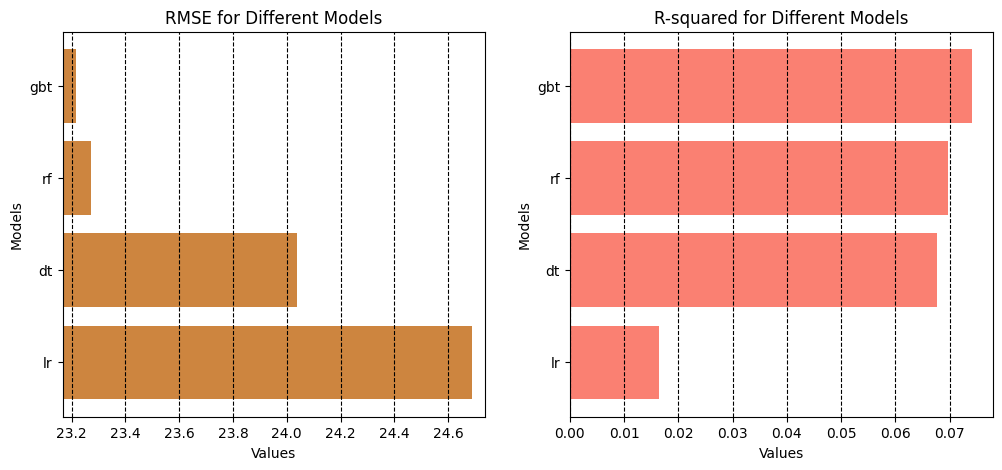

In [0]:
import matplotlib.pyplot as plt

model_labels = ['lr', 'dt', 'rf', 'gbt']
rmse_values = [rmse_lr, rmse_dt, rmse_rf, rmse_gbt]
# rmse_values = [25.44285, 24.79613, 24.83823, 24.77321]

# rmse_values = [round(x, 5) for x in rmse_values]

r2_values = [r2_lr, r2_dt, r2_rf, r2_gbt]
# r2_values =  [0.01515, 0.06458, 0.0614, 0.06631]

plt.figure(figsize=[12,5])

plt.subplot(1, 2, 1)
plt.barh(model_labels, rmse_values, color= 'peru')
plt.xlabel('Values')
plt.ylabel('Models')
plt.title('RMSE for Different Models')
plt.xlim(min(rmse_values) -0.05, max(rmse_values) +0.05)
plt.grid(axis='x', color='k', ls= '--')

plt.subplot(1, 2, 2)
plt.barh(model_labels, r2_values, color='salmon')
plt.xlabel('Values')
plt.ylabel('Models')
plt.title('R-squared for Different Models')
plt.grid(axis='x', color='k', ls= '--')
plt.show()

### Finding which model is the best based on RMSE and R2
The if-elif statements are used to find the best model and assign it to the variable best_model and best_intial_model

In [0]:
# finding which model is the best based on rmse and r2
# the if-elif statements are used to find the best model are assign it to the varible best_model

min_rmse = min(rmse_lr, rmse_dt, rmse_rf, rmse_gbt)
max_r2 = max(r2_lr, r2_dt, r2_rf, r2_gbt)

# Initialize best_model and best_intial_model
best_model = None
best_intial_model = None

if (min_rmse == rmse_lr and max_r2 == r2_lr):
    best_model = lr_model        # lr_model
    best_intial_model = lr       # lr

elif(min_rmse == rmse_dt and max_r2 == r2_dt):
    best_model = dt_model        # dt_model
    best_intial_model = dt       # dt

elif(min_rmse == rmse_rf and max_r2 == r2_rf):
    best_model = rf_model        # rf_model
    best_intial_model = rf       # rf

elif(min_rmse == rmse_gbt and max_r2 == r2_gbt):
    best_model = gbt_model       # gbt_model
    best_intial_model = gbt      # gbt

else:
    print("No best model")

print(f"The best model: {best_model}")
print()
print(f"The best initial model: {best_intial_model}")

The best model: GBTRegressionModel: uid=GBTRegressor_17b796f9760d, numTrees=10, numFeatures=2

The best initial model: GBTRegressor_17b796f9760d


### **Justifying My Answer**

The model I recommend using is the **Gradient-Boosted Tree (gbt) model**.

Gradient-Boosted Tree is the best model built out of the four regression models: linear regression with elastic net Regularizers, simple tree model, random forest model, and Gradient-Boosted Tree.

Since the Gradient-Boosted Tree model's Root Mean Squared Error (RMSE) is the closest to 0, it is the best; it is the lowest of the other models.

Then, the Gradient-Boosted Tree model's R squared (r2) is the best because it is the closest to 1. It is the highest out of the other models.


# 9. Please perform hyperparameter tuning on the model you selected in step 8. (sine it is a huge dataset, you may use 1 parameter for each hyperparameters to save time)

### Universal Hyperparameter Tuning
#### (distinct parameters that can be used for any model)
I created if-elif statements that identify the best initial model compared to lr, rf, dt, and gbt.

Do not use CrossValidator is very expensive. Instead, **use the Train-Validation Split, which is less expensive**.

In [0]:
# hyperparameter tuning on the best model using Train Validation Split and parameter grid builder
# libraries for Train Validation Split and parameter grid builder
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

# Hyperparameter Tuning parameter that can be used for any model

# parameter grid builder
if (best_intial_model == lr): # For lr
  print(f"The best_intial_model is {best_intial_model} (lr)")
  paramGrid = ParamGridBuilder().addGrid(best_intial_model.regParam, [0.1, 0.01, 10]).build() # using 1 parameter (lr)

# elif (best_intial_model in [dt, rf, gbt]):  # For dt, rf, gbt
#   print(f"The best_intial_model is {best_intial_model} (dt, rf, gbt)")
#   paramGrid = ParamGridBuilder().addGrid(best_intial_model.maxDepth, [3, 4, 5, 6]).build() # using 1 parameter (dt, rf, gbt)

# else:
#   print("No best intial model")


# With the parametersabove the optimal number of cluster is 4.

# Above created Universal Hyperparameter for dt, rf, gbt
# parameters for each model (if needed)

elif (best_intial_model == dt):  # For dt
  print(f"The best_intial_model is {best_intial_model} (dt)")
  paramGrid = ParamGridBuilder().addGrid(best_intial_model.maxDepth, [3, 4, 5, 6]).build() # using 1 parameter (dt)

elif (best_intial_model == rf): # For rf
  print(f"The best_intial_model is {best_intial_model} (rf)")
  paramGrid = ParamGridBuilder().addGrid(best_intial_model.numTrees, [5, 10, 20, 30]).build() # using 1 parameter (rf)

elif (best_intial_model == gbt): # For gbt
  print(f"The best_intial_model is {best_intial_model} (gbt)")      # (removed 2nd parameter took to long just say with 1 parameter)
  paramGrid = ParamGridBuilder().addGrid(best_intial_model.minInstancesPerNode, [1, 2, 5, 10]).build() # using 1 parameter (gbt)

else:
  print("No best intial model")

# TrainValidationSplit
tvs = TrainValidationSplit(estimator=best_intial_model,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(), #Evaluate the model using regression
                           trainRatio=0.80)  # (80/20) 80% for training/ 20% for validation


The best_intial_model is GBTRegressor_17b796f9760d (gbt)


### Regression Evaluation based on Hyperparameter Tuning on the model
One parameter for each hyperparameter

In [0]:
# Run TrainValidationSplit
# since it is a huge dataset, you may use 1 parameter for each hyperparameters to save time
# refit on the whole training dataset

print("TrainValidationSplit results with the parameter I choose")

model_tvs = tvs.fit(trainingData)

# Make predictions on the test data set model with the parameters that performed best.
tvs_predictions = model_tvs.transform(testData)

tvs_predictions.select("features", "label", "prediction").show(5)

#---------------------------------------------------------------------------

# RMSE
rmse_evaluator_tvs = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse_tvs = rmse_evaluator_tvs.evaluate(tvs_predictions)
print(f"Root Mean Squared Error (RMSE) on model_tvs test data = {round(rmse_tvs, 5)}")


#---------------------------------------------------------------------------

# R squared
r2_evaluator_tvs = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
r2_tvs = r2_evaluator_tvs.evaluate(tvs_predictions)
print(f"R squared (r2) on model_tvs test data = {round(r2_tvs, 5)}")

TrainValidationSplit results with the parameter I choose
+---------+-----+------------------+
| features|label|        prediction|
+---------+-----+------------------+
|(2,[],[])|  0.0|15.332384130555221|
|(2,[],[])|  0.0|15.332384130555221|
|(2,[],[])|  0.0|15.332384130555221|
|(2,[],[])|  0.0|15.332384130555221|
|(2,[],[])|  0.0|15.332384130555221|
+---------+-----+------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on model_tvs test data = 23.21602
R squared (r2) on model_tvs test data = 0.07419


### Previous Results from the Different Models Before Hyperparameter Tuning

In [0]:
print(f"                   gbt")
print("---------------------------")
print(f"The RMSE's are: {round(rmse_gbt, 5)}")
print(f"The r2's are:   {round(r2_gbt, 5)}")

                   gbt
---------------------------
The RMSE's are: 23.21602
The r2's are:   0.07419


### **Comparing Hyperparameter Tuning Results vs the Previous Results from the Best Model Found**

In [0]:

print(f"rmse_tvs: {rmse_tvs}")
print(f"rmse_gbt: {rmse_gbt}")

if(rmse_tvs == rmse_gbt):
    print(f"rmse_tvs and rmse_gbt are the same: {rmse_tvs == rmse_gbt}")
else:
    print(f"rmse_tvs and rmse_gbt are the same: {rmse_tvs == rmse_gbt}")
    if(min(rmse_tvs, rmse_gbt) == rmse_tvs):
        print(f"rmse_tvs is the closest to 0: {min(rmse_tvs, rmse_gbt) == rmse_tvs}")
    else:
        print(f"rmse_gbt is the closest to 0: {min(rmse_tvs, rmse_gbt) == rmse_gbt}")

print()

print(f"r2_tvs: {r2_tvs}")
print(f"r2_gbt: {r2_gbt}")

if(r2_tvs == r2_gbt):
    print(f"r2_tvs and r2_gbt are the same: {r2_tvs == r2_gbt}")
else:
    print(f"r2_tvs and r2_gbt are the same: {r2_tvs == r2_gbt}")
    if(max(r2_tvs, r2_gbt) == r2_tvs):
        print(f"r2_tvs is the highest: {max(r2_tvs, r2_gbt) == r2_tvs}")
    else:
        print(f"r2_gbt is the highest: {max(r2_tvs, r2_gbt) == r2_gbt}")


rmse_tvs: 23.21602322625551
rmse_gbt: 23.21602322625551
rmse_tvs and rmse_gbt are the same: True

r2_tvs: 0.07418946635199608
r2_gbt: 0.07418946635199597
r2_tvs and r2_gbt are the same: False
r2_tvs is the highest: True


Slight improvement occurred between performing Hyperparameter Tuning and the Gradient-Boosted Tree model results. Both have the same RMSE of 24.76347, but for R squared the Hyperparameter Tuning did slightly better.

In [0]:
df.show(1)

+----+------------+----------+-----------+-----+
|fare|trip_seconds|trip_miles|   features|label|
+----+------------+----------+-----------+-----+
| 4.5|         180|       0.4|[180.0,0.4]|  4.5|
+----+------------+----------+-----------+-----+
only showing top 1 row



# 10. Perform k-means clustering using features trip_seconds, trip_miles, and fare. Please recommend the optimal number of clusters and justify your answer.

There is no label in k-means, only features for clustering. Create a new vector assembler with the trip_seconds, trip_miles, and fare columns and name a new vector assembler kmeans_assembler.

In [0]:
# df.show(1)

### Creating a variable that selects only the features trip_seconds, trip_miles, and fare from the df
'df_features_clustering3' only has 'trip_seconds', 'trip_miles', and 'fare' columns

In [0]:
# k-means clustering using features trip_seconds, trip_miles, and fare.

# selecting trip_seconds, trip_miles, and fare columns for the variable
df_features_clustering3 = df.select('trip_seconds', 'trip_miles', 'fare')

df_features_clustering3.show(5)


+------------+----------+-----+
|trip_seconds|trip_miles| fare|
+------------+----------+-----+
|         180|       0.4|  4.5|
|         240|       0.7| 4.45|
|           0|       0.0|42.75|
|         480|       1.1|  7.0|
|         480|      2.71|10.25|
+------------+----------+-----+
only showing top 5 rows



### Create a new vector assembler with the trip_seconds, trip_miles, and fare columns and name a new vector assembler kmeans_assembler


In [0]:
#Perform k-means clustering using features trip_seconds, trip_miles, and fare.

# library for K Means clustering
from pyspark.ml.clustering import KMeans

# evaluate the model indirectly
from pyspark.ml.evaluation import ClusteringEvaluator

# plot the kmeans
import matplotlib.pyplot as plt


# create a new vector assembler with the trip_seconds, trip_miles, and fare columns and name a new vector assembler kmeans_assembler

kmeans_assembler = VectorAssembler(
    inputCols=['trip_seconds', 'trip_miles', 'fare'],
    outputCol='kmeans_features')

# Note: df_features_clustering3 only has trip_seconds, trip_miles, and fare columns

kmeans_assembler_output = kmeans_assembler.transform(df_features_clustering3) # transforming assembler on df_features_clustering3 don't need split

kmeans_df = kmeans_assembler_output # assigning kmeans_assembler_output to kmeans_df

print("kmeans assembled columns: 'trip_seconds', 'trip_miles', 'fare' columns into a 'kmeans_features' column")

kmeans_df.select('kmeans_features').show(truncate=False)

kmeans assembled columns: 'trip_seconds', 'trip_miles', 'fare' columns into a 'kmeans_features' column
+------------------+
|kmeans_features   |
+------------------+
|[180.0,0.4,4.5]   |
|[240.0,0.7,4.45]  |
|[0.0,0.0,42.75]   |
|[480.0,1.1,7.0]   |
|[480.0,2.71,10.25]|
|[1080.0,6.2,17.75]|
|[60.0,0.2,3.75]   |
|[180.0,0.0,5.0]   |
|[0.0,0.0,3.25]    |
|[480.0,1.3,7.0]   |
|[420.0,0.0,7.25]  |
|[1380.0,5.1,17.25]|
|[420.0,0.0,6.25]  |
|[480.0,0.1,9.0]   |
|[720.0,0.0,10.75] |
|[720.0,2.2,10.0]  |
|[300.0,0.8,5.5]   |
|[420.0,0.0,6.75]  |
|[660.0,4.1,11.85] |
|[720.0,2.5,10.25] |
+------------------+
only showing top 20 rows



In [0]:
kmeans_df.show(5)

+------------+----------+-----+------------------+
|trip_seconds|trip_miles| fare|   kmeans_features|
+------------+----------+-----+------------------+
|         180|       0.4|  4.5|   [180.0,0.4,4.5]|
|         240|       0.7| 4.45|  [240.0,0.7,4.45]|
|           0|       0.0|42.75|   [0.0,0.0,42.75]|
|         480|       1.1|  7.0|   [480.0,1.1,7.0]|
|         480|      2.71|10.25|[480.0,2.71,10.25]|
+------------+----------+-----+------------------+
only showing top 5 rows



### Finding the optimal number of clusters

In [0]:
#Please recommend the optimal number of clusters and justify your answer.

# find the optimal number of clusters

Silhvalues = []

kmeans_range = range(2, 11)

for k in kmeans_range:

    kmeans = KMeans(featuresCol="kmeans_features").setK(k).setSeed(1) # specifying that the featrues column is named "kmeans_features"

    kmeans_model = kmeans.fit(kmeans_df) # use kmeans_df

    # Make predictions
    kmeans_predictions = kmeans_model.transform(kmeans_df)

    # Evaluate clustering by computing Silhouette score (internally evaluate the model)
    evaluator = ClusteringEvaluator(featuresCol="kmeans_features") # specifying the feature column is named "kmeans_features"

    silhouette = evaluator.evaluate(kmeans_predictions)
    Silhvalues.append(silhouette)

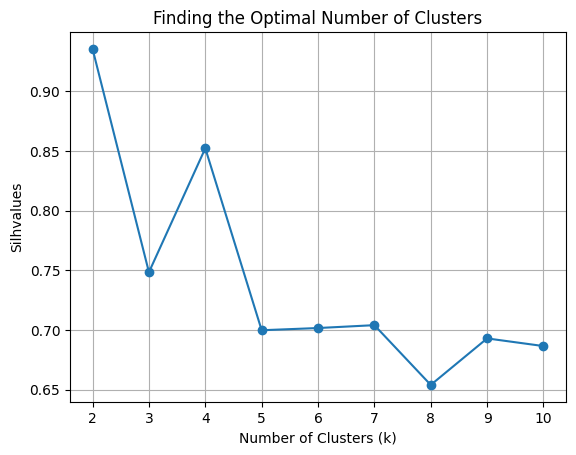

In [0]:
plt.plot(kmeans_range, Silhvalues, marker='o')
plt.title('Finding the Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhvalues')
plt.grid()
plt.show()
# Note: All 20 million records have been used

### **Please recommend the optimal number of clusters and justify your answer.**

The optimal number of clusters based on the plot is **4**.

The plot shows the silhouette values for different cluster numbers. The highest silhouette value is 2 (1.00), but it is NOT the optimal number of clusters because it may oversimplify the data. Then, with the elbow method, the cluster is 5 (about 0.75), but it does not have a good/high silhouette value compared to cluster 4.

The optimal number of clusters is 4 (about 0.85) because it has the second-highest silhouette value, well-balanced complexity, and cluster quality. Cluster 4 avoids oversimplification.


Note: All 20 million records have been used

### k-means clustering with the recommended optimal number of clusters
The optimal number of clusters is 4.

In [0]:
opt_k = 4 # the optimal number of clusters (all data used)

optimal_kmeans = KMeans(featuresCol="kmeans_features").setK(opt_k).setSeed(1) # specifying that the featrues column is named "kmeans_features"


optimal_kmeans_model = optimal_kmeans.fit(kmeans_df) # use kmeans_df

# Make predictions
opt_kmeans_predictions = optimal_kmeans_model.transform(kmeans_df) # use kmeans_df

opt_kmeans_predictions.select("kmeans_features", "prediction").show(5)


# evaluating the optimal model

# Evaluate clustering by computing Silhouette score (internally evaluate the model)
opt_kmeans_evaluator = ClusteringEvaluator(featuresCol="kmeans_features") # specifying the feature column is named "kmeans_features"

opt_silhouette = opt_kmeans_evaluator.evaluate(opt_kmeans_predictions)

print("Optimal Silhouette with Squared Euclidean Distance = " + str(opt_silhouette))
print()

#--------------------------------------------------------------------------------------


# showing the results of the cluster_centers.
cluster_centers = optimal_kmeans_model.clusterCenters()

print("Cluster Centers: ")
for center in cluster_centers:
    print(center)

+------------------+----------+
|   kmeans_features|prediction|
+------------------+----------+
|   [180.0,0.4,4.5]|         0|
|  [240.0,0.7,4.45]|         0|
|   [0.0,0.0,42.75]|         0|
|   [480.0,1.1,7.0]|         0|
|[480.0,2.71,10.25]|         0|
+------------------+----------+
only showing top 5 rows

Optimal Silhouette with Squared Euclidean Distance = 0.8521441233380682

Cluster Centers: 
[457.26099195   1.14800085   8.96469956]
[1715.25964959    1.97227635   24.6265969 ]
[6.59104629e+04 7.40900723e-01 3.05999080e+01]
[2.74795635e+04 1.06975956e+00 5.04249137e+01]


Please develop your models. You may get help from your classmates. When you debug the models, you may use a smaller dataset, for example, 5,000 rows. After you fix all bugs, then run the whole dataset, for example at 9pm, then you will get some results in the morning,

Since it is a very large dataset, it takes about 12 hours on my laptop to run all the models. You need to summarize your model results in a PPT file and present your own research finding on Monday, December 9 or Wednesday, December 11,  2024 in the classroom.

You must upload the following three files  into Canvas after your presentation:

+ Jupyter Notebook
+ HTML file
+ PPT File


Each student has about 15 minutes.